As shown in this github issue: https://github.com/scikit-learn/scikit-learn/issues/5975

I've had many arguements that for poisson regression Counts/Exposures is equivalent to handling the offsets in the optimization loop explicitly. This isn't true as shown later on in this notebook.

The notebook also shows how to do poisson regression with offsets in tensorflow. Pretty baller right.

In [1]:
import numpy as np
import pandas as pd

In [180]:
np.random.seed(333)
n = 1000000
df = pd.DataFrame(
    np.random.normal(np.tile(np.arange(10), n), np.tile(np.arange(1, 11) * 2, n), (n * 10)).reshape((n, 10)) / 100)
wts = np.array([-0.1, -0.2, 0, 0, 0.1, 0.2, 0.3, 0.0, 0.25, 0.5])
df['y'] = (df.values * wts).sum(axis=1)
df['rate'] = np.exp(df['y'])

In [181]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,y,rate
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,-0.000003,0.009928,0.020052,0.029953,0.039883,0.050059,0.060012,0.070168,0.080178,0.090096,0.095111,1.107802
std,0.020028,0.040016,0.060064,0.080018,0.099852,0.120065,0.140026,0.159790,0.180064,0.199852,0.120557,0.134044
min,-0.105630,-0.209110,-0.309568,-0.352887,-0.421594,-0.500034,-0.681308,-0.690213,-0.801777,-0.907063,-0.481539,0.617832
25%,-0.013521,-0.017128,-0.020421,-0.024039,-0.027489,-0.030903,-0.034518,-0.037456,-0.041322,-0.044670,0.013792,1.013888
50%,-0.000023,0.009892,0.020028,0.029904,0.039912,0.050219,0.060004,0.070210,0.079852,0.090129,0.095101,1.099770
75%,0.013515,0.036934,0.060464,0.083954,0.107181,0.131026,0.154161,0.178102,0.201702,0.224866,0.176557,1.193102
max,0.095576,0.200082,0.317362,0.410525,0.560201,0.682567,0.761380,0.846154,0.957091,1.058712,0.673366,1.960826


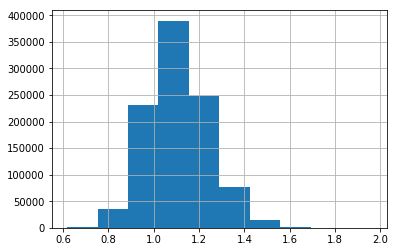

In [182]:
%matplotlib inline
df.rate.hist()

In [183]:
df['offset'] = np.random.randint(1, 10, n)

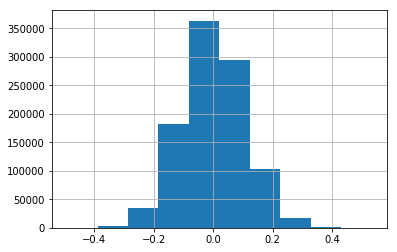

In [184]:
(np.random.poisson(df['rate'], (10, n)).T.mean(axis=1) - df.rate).hist()

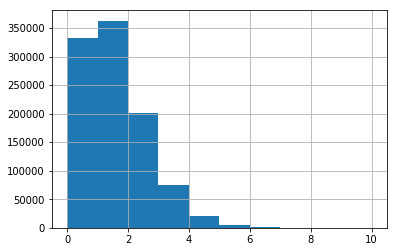

In [185]:
df['cnt'] = np.random.poisson(df['rate'])
df.cnt.hist()

In [187]:
import statsmodels.api as sm


mod = sm.GLM(df['cnt'], df[np.arange(10)], family=sm.families.Poisson())

mod = mod.fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    cnt   No. Observations:              1000000
Model:                            GLM   Df Residuals:                   999990
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.3606e+06
Date:                Mon, 12 Feb 2018   Deviance:                   1.1522e+06
Time:                        21:18:44   Pearson chi2:                 1.00e+06
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1093      0.047     -2.303      0.021      -0.202      -0.016
1             -0.2031      0.023     -8.646      0.000      -0.249      -0.157
2              0.0097      0.015      0.626      0.531      -0.021       0.040
3              0.0008      0.012      0.069      0.945      -0.022       0.023
4              0.0944      0.009     10.253      0.000       0.076       0.112
5              0.1912      0.008     25.097      0.000       0.176       0.206
6              0.3053      0.006     47.020      0.000       0.293       0.318
7             -0.0041      0.006     -0.716      0.474      -0.015       0.007
8              0.2543      0.005     50.560      0.000       0.244       0.264
9              0.4978      0.004    111.282      0.000       0.489       0.507
==============================================================================
"""

In [188]:
df['cnt'] = [np.random.poisson(rate, offset).sum() for rate, offset in zip(df['rate'], df['offset'])]

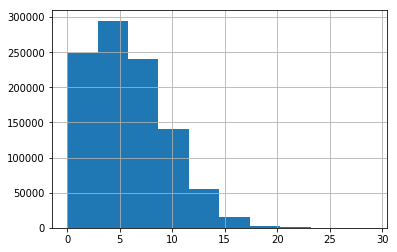

In [189]:
df.cnt.hist()

In [192]:
import statsmodels.api as sm


mod = sm.GLM(df['cnt'], df[np.arange(10)], offset=np.log(df['offset']), family=sm.families.Poisson())

mod = mod.fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    cnt   No. Observations:              1000000
Model:                            GLM   Df Residuals:                   999990
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -2.1458e+06
Date:                Mon, 12 Feb 2018   Deviance:                   1.0616e+06
Time:                        21:19:50   Pearson chi2:                 9.98e+05
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0757      0.021     -3.569      0.000      -0.117      -0.034
1             -0.2146      0.011    -20.415      0.000      -0.235      -0.194
2             -0.0060      0.007     -0.870      0.384      -0.020       0.008
3             -0.0071      0.005     -1.369      0.171      -0.017       0.003
4              0.1057      0.004     25.683      0.000       0.098       0.114
5              0.2010      0.003     59.013      0.000       0.194       0.208
6              0.2976      0.003    102.507      0.000       0.292       0.303
7             -0.0033      0.003     -1.301      0.193      -0.008       0.002
8              0.2496      0.002    111.029      0.000       0.245       0.254
9              0.4987      0.002    249.294      0.000       0.495       0.503
==============================================================================
"""

In [194]:
import statsmodels.api as sm


mod = sm.GLM(df['cnt'] / df['offset'], df[np.arange(10)], family=sm.families.Poisson())

mod = mod.fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:              1000000
Model:                            GLM   Df Residuals:                   999990
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.1432e+06
Date:                Mon, 12 Feb 2018   Deviance:                   3.4568e+05
Time:                        21:25:05   Pearson chi2:                 3.14e+05
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0644      0.047     -1.357      0.175      -0.157       0.029
1             -0.2159      0.023     -9.191      0.000      -0.262      -0.170
2             -0.0064      0.015     -0.411      0.681      -0.037       0.024
3             -0.0102      0.012     -0.883      0.377      -0.033       0.012
4              0.1066      0.009     11.574      0.000       0.089       0.125
5              0.1994      0.008     26.177      0.000       0.184       0.214
6              0.2994      0.006     46.098      0.000       0.287       0.312
7             -0.0018      0.006     -0.317      0.752      -0.013       0.009
8              0.2511      0.005     49.914      0.000       0.241       0.261
9              0.4991      0.004    111.565      0.000       0.490       0.508
==============================================================================
"""

In [327]:
from pyglmnet import GLM

# create an instance of the GLM class
glm = GLM(distr='poisson')
glm = glm.fit(df[np.arange(10)].values, df['cnt'].values/df['offset'].values)
glm

<
Distribution | poisson
alpha | 0.50
max_iter | 1000.00
lambda: 0.50 to 0.01
>

In [328]:
glm.get_params()

{'Tau': None,
 'alpha': 0.5,
 'distr': 'poisson',
 'eta': 4.0,
 'group': None,
 'learning_rate': 0.2,
 'max_iter': 1000,
 'random_state': 0,
 'reg_lambda': array([ 0.5       ,  0.3237394 ,  0.2096144 ,  0.13572088,  0.08787639,
         0.0568981 ,  0.03684031,  0.02385332,  0.01544452,  0.01      ]),
 'score_metric': 'deviance',
 'tol': 0.001,
 'verbose': False}

In [313]:
import keras

inl = keras.layers.Input((10,))
out = keras.layers.Dense(1, use_bias=False)(inl)
out = keras.layers.Lambda(lambda x: keras.backend.exp(x))(out)
model = keras.models.Model(inl, out)

model.compile(keras.optimizers.Adam(1e-3), 'poisson')
model.summary()
model.fit(df[np.arange(10)], df['cnt']/df['offset'], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 10        
_________________________________________________________________
lambda_18 (Lambda)           (None, 1)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
1000000/1000000 [==============================] - 25s 25us/step - loss: 0.9870


In [314]:
model.get_weights()[0].ravel()

array([-0.05754524, -0.23257338,  0.00755339, -0.05471236,  0.12637407,
        0.19810426,  0.2976492 , -0.01716288,  0.26042998,  0.51705188], dtype=float32)

In [310]:
import keras

inl = keras.layers.Input((10,))
out = keras.layers.Dense(1, use_bias=False)(inl)
off = keras.layers.Input((1,))
out = keras.layers.add([out, off])
out = keras.layers.Lambda(lambda x: keras.backend.exp(x))(out)

model = keras.models.Model([inl, off], out)

model.compile(keras.optimizers.Adam(1e-3), 'poisson')
model.summary()
model.fit([df[np.arange(10)], np.log(df['offset'])], df['cnt'], verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 1)            10          input_29[0][0]                   
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
add_3 (Add)                     (None, 1)            0           dense_20[0][0]                   
                                                                 input_30[0][0]                   
__________

In [311]:
model.get_weights()[0].ravel()

array([-0.09250503, -0.19198173, -0.04260972, -0.02864283,  0.11696044,
        0.20959049,  0.29357442, -0.02965078,  0.23306984,  0.48882231], dtype=float32)

In [ ]:
# now with unequal number of exposures we need to use the offsets correctly to get the right answer

In [341]:
offsets = np.arange(1, 101)
import itertools
offsets=np.array(list(itertools.chain.from_iterable([np.repeat(i, off) for i, off in enumerate(offsets)])))
X=np.array([x/100 for x in offsets])[:, np.newaxis]
X.shape, offsets.shape

((5050, 1), (5050,))

In [342]:
y=np.random.poisson(np.exp(X*1.2+.33)).ravel()
y.shape

(5050,)

In [343]:
mod = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson())

mod = mod.fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5050
Model:                            GLM   Df Residuals:                     5048
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -9733.6
Date:                Mon, 12 Feb 2018   Deviance:                       5327.1
Time:                        22:54:05   Pearson chi2:                 4.88e+03
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3279      0.028     11.874      0.000       0.274       0.382
x1             1.2006      0.037     32.733      0.000       1.129       1.272
==============================================================================
"""

In [345]:
Xg=pd.DataFrame(X).groupby(offsets).mean().values
yg=pd.DataFrame(y).groupby(offsets).sum().values.ravel()
Xg.shape, yg.shape

((100, 1), (100,))

In [346]:
offsetsg = pd.DataFrame(offsets).groupby(offsets).size().values.ravel()

In [347]:
mod = sm.GLM(yg, sm.add_constant(Xg), offset=np.log(offsetsg), family=sm.families.Poisson())

mod = mod.fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -368.64
Date:                Mon, 12 Feb 2018   Deviance:                       97.737
Time:                        22:56:15   Pearson chi2:                     98.3
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3279      0.028     11.874      0.000       0.274       0.382
x1             1.2006      0.037     32.733      0.000       1.129       1.272
==============================================================================
"""

In [348]:
mod = sm.GLM(yg/offsetsg, sm.add_constant(Xg), family=sm.families.Poisson())

mod = mod.fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -144.13
Date:                Mon, 12 Feb 2018   Deviance:                       5.7707
Time:                        22:57:02   Pearson chi2:                     6.43
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3547      0.143      2.485      0.013       0.075       0.634
x1             1.1635      0.219      5.320      0.000       0.735       1.592
==============================================================================
"""

In [349]:
# wow amazing dividing by exposures doesn't work!!!! Guess you actually have use the math to be correct :)

In [350]:
# bonus let's try tensorflow

In [465]:
import keras

inl = keras.layers.Input((2,))
out = keras.layers.Dense(1, use_bias=False)(inl)
off = keras.layers.Input((1,))
out = keras.layers.add([out, off])
out = keras.layers.Lambda(lambda x: keras.backend.exp(x))(out)

model = keras.models.Model([inl, off], out)

model.compile(keras.optimizers.SGD(1e-19), 'poisson')
model.summary()
model.fit([sm.add_constant(Xg), np.log(offsetsg)], yg, verbose=1, epochs=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_145 (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
dense_79 (Dense)                (None, 1)            2           input_145[0][0]                  
__________________________________________________________________________________________________
input_146 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
add_60 (Add)                    (None, 1)            0           dense_79[0][0]                   
                                                                 input_146[0][0]                  
__________

In [466]:
model.get_weights()[0]

array([[-1.10750854],
       [ 0.13667548]], dtype=float32)